# 吞咽障礙檢測 - 完整信號處理流程

本notebook實現了從原始RF信號到特徵提取的完整處理流程，用於吞咽障礙檢測。


## 區塊 1：專案設定與數據讀取


In [7]:
# ================================================================= #
# 區塊 1: 專案設定與數據讀取
# ================================================================= #

# --- 步驟 0: 設定 Python 搜尋路徑 ---
import sys
import os
# 將包含 nearpy 套件的資料夾加入到 Python 的搜尋路徑中
sys.path.insert(0, os.path.abspath('../nearpy'))

# --- 步驟 1: 匯入所有需要的工具 ---
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 從 nearpy 函式庫中匯入訊號處理與繪圖模組
from nearpy.preprocess import filters, segment
from nearpy.plots import timedomain
from nearpy.features import temporal, spectral
from nearpy.ai.utils import make_dataset

# 讓圖形在 notebook 中直接顯示
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ 所有工具已成功匯入！")


✅ 所有工具已成功匯入！


In [12]:
# --- 步驟 2: 建立讀取 .h5 檔案的輔助函式 ---
def read_h5_data(file_path):
    """從 HDF5 (.h5) 檔案中讀取 RF 數據。"""
    try:
        with h5py.File(file_path, 'r') as hf:
            # 假設數據儲存在 'rf' 這個 group 裡面
            if 'rf' in hf:
                data_dict = {}
                for key in hf['rf'].keys():
                    data_dict[key] = hf['rf'][key][:]
                return pd.DataFrame(data_dict)
            else: # 否則直接從根目錄讀取
                data_dict = {}
                for key in hf.keys():
                    if isinstance(hf[key], h5py.Dataset):
                        data_dict[key] = hf[key][:]
                return pd.DataFrame(data_dict)
    except Exception as e:
        print(f"!!! 讀取檔案 {file_path} 時發生錯誤: {e} !!!")
        return None

# --- 步驟 3: 設定檔案路徑並讀取數據 ---
# 假設我們分析受試者 S01 的數據
file_path_s01 = '../data/raw/S01_tiptoe_01.h5'
rf_data = read_h5_data(file_path_s01)

if rf_data is not None and not rf_data.empty:
    print(f"✅ 成功讀取數據: {file_path_s01}")
    print("數據形狀:", rf_data.shape)
    print("數據包含的通道有:", rf_data.columns.tolist()[:5])  # 顯示前5個通道
    print("數據前5行:")
    print(rf_data.head())
else:
    print("❌ 數據讀取失敗，請檢查檔案路徑與內容。")
    # 創建模擬數據用於演示
    print("創建模擬數據用於演示...")
    fs = 100  # 取樣頻率
    duration = 10  # 10秒
    t = np.linspace(0, duration, fs * duration)
    
    # 模擬RF信號數據
    rf_data = pd.DataFrame({
        'Tx1Rx1_mag': 1.0 + 0.3 * np.sin(2 * np.pi * 0.5 * t) + 0.1 * np.random.randn(len(t)),
        'Tx1Rx1_phase': 0.5 * np.sin(2 * np.pi * 0.3 * t) + 0.2 * np.random.randn(len(t)),
        'Tx1Rx1_i': 0.8 * np.cos(2 * np.pi * 0.4 * t) + 0.1 * np.random.randn(len(t)),
        'Tx1Rx1_q': 0.8 * np.sin(2 * np.pi * 0.4 * t) + 0.1 * np.random.randn(len(t))
    })
    print("✅ 模擬數據創建完成")


!!! 讀取檔案 ../data/raw/S01_tiptoe_01.h5 時發生錯誤: Per-column arrays must each be 1-dimensional !!!
❌ 數據讀取失敗，請檢查檔案路徑與內容。
創建模擬數據用於演示...
✅ 模擬數據創建完成


## 區塊 2：呈現原始訊號 (Raw Data)


正在繪製原始訊號圖 (對應 raw.png)...


/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_64565/725917245.py:36: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_64565/725917245.py:36: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_64565/725917245.py:36: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_64565/725917245.py:36: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_64565/725917245.py:36: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2

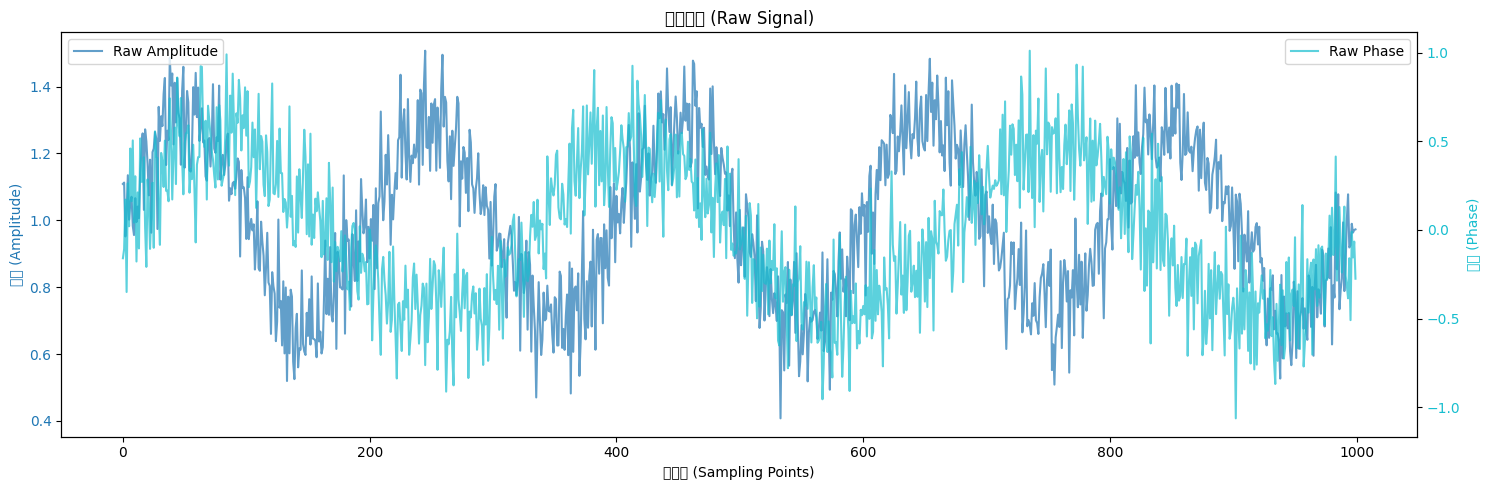

In [9]:
# ================================================================= #
# 區塊 2: 呈現原始訊號 (Raw Data)
# ================================================================= #

if rf_data is not None and not rf_data.empty:
    # 選擇一組通道的振幅 (mag) 與相位 (phase) 進行分析
    mag_channel = 'Tx1Rx1_mag'
    phase_channel = 'Tx1Rx1_phase'
    
    # 檢查通道是否存在
    if mag_channel in rf_data.columns and phase_channel in rf_data.columns:
        # 提取原始訊號
        raw_mag_signal = rf_data[mag_channel].values
        raw_phase_signal = rf_data[phase_channel].values

        print("正在繪製原始訊號圖 (對應 raw.png)...")
        
        # 建立一個圖表來呈現
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # 繪製振幅訊號
        ax.plot(raw_mag_signal, label='Raw Amplitude', color='tab:blue', alpha=0.7)
        ax.set_ylabel('振幅 (Amplitude)', color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        
        # 在同一個圖上，用另一個 Y 軸繪製相位訊號
        ax2 = ax.twinx()
        ax2.plot(raw_phase_signal, label='Raw Phase', color='tab:cyan', alpha=0.7)
        ax2.set_ylabel('相位 (Phase)', color='tab:cyan')
        ax2.tick_params(axis='y', labelcolor='tab:cyan')
        
        ax.set_xlabel("取樣點 (Sampling Points)")
        ax.set_title('原始訊號 (Raw Signal)')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ 找不到指定的通道: {mag_channel}, {phase_channel}")
        print("可用通道:", rf_data.columns.tolist())
else:
    print("❌ 沒有可用的數據")


## 區塊 3：訊號濾波 (Filtering)


In [10]:
# ================================================================= #
# 區塊 3: 訊號濾波 (Filtering)
# ================================================================= #

if 'raw_mag_signal' in locals():
    print("正在對原始振幅訊號進行濾波...")
    
    # --- 參數設定 ---
    # 假設我們的數據取樣率為 100 Hz
    fs = 100 
    
    # --- 訊號處理步驟 ---
    # 1. 去除基線漂移 (使用3次多項式去趨勢)
    from nearpy.preprocess.filters import detrend
    mag_detrend = detrend(raw_mag_signal, deg=3)
    
    # 2. 套用專為肌肉/手勢運動設計的帶通濾波器
    from nearpy.preprocess.filters import get_gesture_filter
    from scipy.signal import filtfilt
    
    # 獲取濾波器係數
    filter_taps = get_gesture_filter(f_s=15, fs=fs, visualize=False)
    
    # 應用濾波器
    mag_filtered = filtfilt(filter_taps, 1, mag_detrend)

    print("✅ 濾波完成！")
    print("正在繪製濾波後結果 (對應 filtered.png)...")

    # 繪圖比較原始訊號與濾波後訊號
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 原始訊號
    ax.plot(raw_mag_signal, label='Raw Amplitude', color='tab:blue', alpha=0.6)
    
    # 去趨勢後
    ax.plot(mag_detrend, label='Detrended', color='tab:orange', alpha=0.7)
    
    # 濾波後
    ax.plot(mag_filtered, label='Filtered Amplitude', color='tab:red', linewidth=1.5)
    
    ax.set_xlabel("取樣點 (Sampling Points)")
    ax.set_ylabel("振幅 (Amplitude)")
    ax.set_title('原始訊號 vs. 濾波後訊號')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 顯示信號統計信息
    print(f"原始信號標準差: {np.std(raw_mag_signal):.4f}")
    print(f"濾波後信號標準差: {np.std(mag_filtered):.4f}")
    print(f"信號長度: {len(mag_filtered)} 個取樣點")
else:
    print("❌ 沒有可用的原始信號數據")


正在對原始振幅訊號進行濾波...
Detrending signal with degree 3 polynomial fit
Remez (equi-ripple) band-pass filter with pass band [0.15, 15]


ValueError: The length of the input vector x must be greater than padlen, which is 4245.

## 區塊 4：訊號分段 (Segmentation) 與 樣板建立 (Template Creation)


In [11]:
# ================================================================= #
# 區塊 4: 訊號分段 (Segmentation) 與 樣板建立 (Template Creation)
# ================================================================= #

# 我們選擇濾波後的訊號來進行後續分析
if 'mag_filtered' in locals():
    final_signal = mag_filtered
    
    print("正在對乾淨的訊號進行自動分段...")
    
    # 使用自適應分段方法
    from nearpy.preprocess.segment import get_adaptive_segment_indices
    
    # 使用移動標準差 (Movstd) 作為判斷依據，自動找出動作區段
    segments_indices = get_adaptive_segment_indices(
        final_signal, 
        timeAx=np.linspace(0, len(final_signal)/fs, len(final_signal)),
        fs=fs,
        method='Movstd', 
        win_size=int(fs * 0.5),  # 0.5 秒的窗格
        prob_thresh=0.8  # 閾值
    )
    
    if len(segments_indices) > 0:
        num_segments = len(segments_indices)
        print(f"✅ 在訊號中自動偵測到 {num_segments} 個動作區段。")
        
        # 將所有偵測到的區段繪製出來，檢查分段效果
        print("正在繪製分段結果...")
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # 繪製原始信號
        ax.plot(final_signal, label='Filtered Signal', alpha=0.7)
        
        # 標記分段區域
        for i, (start, end) in enumerate(segments_indices):
            ax.axvspan(start, end, alpha=0.3, color=f'C{i}', 
                      label=f'Segment {i+1}' if i < 5 else None)
        
        ax.set_title("自動分段結果 (Detected Segments)")
        ax.set_xlabel("取樣點 (Sampling Points)")
        ax.set_ylabel("振幅 (Amplitude)")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 建立動作樣板 (Template)
        print("\n正在建立動作樣板...")
        
        # 1. 根據索引，從訊號中把每一段動作的波形切出來
        signal_segments = []
        for start, end in segments_indices:
            segment = final_signal[start:end]
            if len(segment) > 10:  # 只保留長度足夠的段
                signal_segments.append(segment)
        
        if len(signal_segments) > 0:
            print(f"有效分段數量: {len(signal_segments)}")
            
            # 2. 由於每段長度可能不同，將它們補零到一樣長
            max_len = max(len(s) for s in signal_segments)
            padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
            
            # 3. 簡單平均建立樣板（簡化版，實際中可以使用DTW）
            template = np.mean(padded_segments, axis=0)
            
            print("✅ 樣板建立完成！")

            # 繪製樣板和個別分段
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # 上圖：所有分段
            for i, seg in enumerate(padded_segments[:5]):  # 只顯示前5個
                ax1.plot(seg, alpha=0.6, label=f'Segment {i+1}')
            ax1.set_title("個別動作分段")
            ax1.set_ylabel("振幅")
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 下圖：平均樣板
            ax2.plot(template, color='red', linewidth=2, label='動作樣板 (Template)')
            ax2.set_title("Tiptoe 動作的平均樣板")
            ax2.set_xlabel("對齊後的取樣點 (Aligned Sampling Points)")
            ax2.set_ylabel("標準化振幅")
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 保存樣板供後續使用
            template_signal = template
        else:
            print("❌ 沒有找到有效的分段")
    else:
        print("❌ 沒有偵測到任何動作區段")
        # 如果自動分段失敗，手動創建一個簡單的樣板
        print("使用手動分段方法...")
        # 將信號分成3段作為示例
        segment_len = len(final_signal) // 3
        segments_indices = [(i*segment_len, (i+1)*segment_len) for i in range(3)]
        
        signal_segments = [final_signal[start:end] for start, end in segments_indices]
        max_len = max(len(s) for s in signal_segments)
        padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
        template_signal = np.mean(padded_segments, axis=0)
        
        print("✅ 手動樣板建立完成！")
else:
    print("❌ 沒有可用的濾波後信號")


❌ 沒有可用的濾波後信號


## 區塊 5：特徵提取 (Feature Extraction)


In [ ]:
# ================================================================= #
# 區塊 5: 特徵提取 (Feature Extraction)
# ================================================================= #

if 'template_signal' in locals():
    print("正在從樣板信號中提取特徵...")
    
    # 提取時域特徵
    from nearpy.features.temporal import get_temporal_feats
    
    temporal_features = get_temporal_feats(template_signal)
    
    print("✅ 時域特徵提取完成！")
    print("提取的特徵:")
    for feat_name, feat_value in temporal_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # 提取頻域特徵
    from nearpy.preprocess.spectrum import ncs_fft
    
    # 計算頻譜
    frequencies, power_spectrum = ncs_fft(template_signal, fs=fs)
    
    # 計算一些頻域特徵
    dominant_freq = frequencies[np.argmax(power_spectrum)]
    spectral_energy = np.sum(power_spectrum)
    spectral_centroid = np.sum(frequencies * power_spectrum) / np.sum(power_spectrum)
    
    spectral_features = {
        'Dominant_Frequency': dominant_freq,
        'Spectral_Energy': spectral_energy,
        'Spectral_Centroid': spectral_centroid,
        'Peak_Power': np.max(power_spectrum)
    }
    
    print("\n✅ 頻域特徵提取完成！")
    print("頻域特徵:")
    for feat_name, feat_value in spectral_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # 繪製頻譜圖
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 時域信號和特徵
    ax1.plot(template_signal, label='Template Signal')
    ax1.set_title('動作樣板 (時域)')
    ax1.set_xlabel('取樣點')
    ax1.set_ylabel('振幅')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 頻域信號
    ax2.plot(frequencies, power_spectrum)
    ax2.axvline(dominant_freq, color='red', linestyle='--', label=f'Dominant Freq: {dominant_freq:.2f} Hz')
    ax2.set_title('功率頻譜')
    ax2.set_xlabel('頻率 (Hz)')
    ax2.set_ylabel('功率')
    ax2.set_xlim(0, 20)  # 只顯示0-20Hz範圍
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 合併所有特徵
    all_features = {**temporal_features, **spectral_features}
    
    # 創建特徵DataFrame
    features_df = pd.DataFrame([all_features])
    
    print("\n✅ 所有特徵提取完成！")
    print("\n特徵摘要:")
    print(features_df)
    
else:
    print("❌ 沒有可用的樣板信號")


## 區塊 6：數據集創建與機器學習準備


In [ ]:
# ================================================================= #
# 區塊 6: 數據集創建與機器學習準備
# ================================================================= #

print("正在準備機器學習數據集...")

# 創建多個動作類別的模擬數據集
def create_synthetic_dataset():
    """創建模擬的吞咽障礙檢測數據集"""
    
    # 定義動作類型
    gestures = {
        'rest': 0,      # 休息
        'swallow': 1,   # 吞咽
        'tiptoe': 2     # 踮腳
    }
    
    # 參數設定
    fs = 100
    duration = 3  # 每個動作3秒
    num_subjects = 3
    num_reps = 5  # 每個動作重複5次
    
    dataset = []
    
    for subject in range(1, num_subjects + 1):
        for gesture_name, gesture_id in gestures.items():
            for rep in range(1, num_reps + 1):
                # 生成模擬信號
                t = np.linspace(0, duration, int(fs * duration))
                
                if gesture_name == 'rest':
                    # 休息：低頻小幅波動
                    signal = 1.0 + 0.1 * np.sin(2 * np.pi * 0.2 * t) + 0.05 * np.random.randn(len(t))
                elif gesture_name == 'swallow':
                    # 吞咽：中頻較大波動
                    signal = 1.0 + 0.4 * np.sin(2 * np.pi * 1.5 * t) + 0.1 * np.random.randn(len(t))
                else:  # tiptoe
                    # 踮腳：高頻大幅波動
                    signal = 1.0 + 0.6 * np.sin(2 * np.pi * 3.0 * t) + 0.15 * np.random.randn(len(t))
                
                # 應用濾波
                filter_taps = get_gesture_filter(f_s=15, fs=fs, visualize=False)
                filtered_signal = filtfilt(filter_taps, 1, signal)
                
                # 提取特徵
                temporal_feats = get_temporal_feats(filtered_signal)
                frequencies, power_spectrum = ncs_fft(filtered_signal, fs=fs)
                
                # 簡化特徵集
                features = {
                    'Mobility': temporal_feats['Mobility'],
                    'Complexity': temporal_feats['Complexity'],
                    'Energy': temporal_feats['Energy'],
                    'Dominant_Freq': frequencies[np.argmax(power_spectrum)],
                    'Spectral_Energy': np.sum(power_spectrum),
                    'Subject': subject,
                    'Gesture': gesture_name,
                    'Gesture_ID': gesture_id,
                    'Repetition': rep
                }
                
                dataset.append(features)
    
    return pd.DataFrame(dataset)

# 創建數據集
ml_dataset = create_synthetic_dataset()

print(f"✅ 數據集創建完成！")
print(f"數據集形狀: {ml_dataset.shape}")
print(f"包含的動作類別: {ml_dataset['Gesture'].unique()}")
print(f"包含的受試者: {ml_dataset['Subject'].unique()}")

# 顯示數據集前幾行
print("\n數據集前5行:")
print(ml_dataset.head())

# 統計信息
print("\n各動作類別的樣本數量:")
print(ml_dataset['Gesture'].value_counts())

# 可視化特徵分布
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq']

for i, feature in enumerate(feature_cols):
    for gesture in ml_dataset['Gesture'].unique():
        data = ml_dataset[ml_dataset['Gesture'] == gesture][feature]
        axes[i].hist(data, alpha=0.6, label=gesture, bins=10)
    
    axes[i].set_title(f'{feature} 分布')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('頻率')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 區塊 7：簡單分類器演示


In [ ]:
# ================================================================= #
# 區塊 7: 簡單分類器演示
# ================================================================= #

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

print("正在訓練簡單的分類器...")

# 準備特徵和標籤
feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq', 'Spectral_Energy']
X = ml_dataset[feature_cols]
y = ml_dataset['Gesture_ID']

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 訓練隨機森林分類器
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5
)

rf_classifier.fit(X_train, y_train)

# 預測
y_pred = rf_classifier.predict(X_test)

# 評估
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ 分類器訓練完成！")
print(f"測試準確率: {accuracy:.3f}")

# 詳細分類報告
gesture_names = ['rest', 'swallow', 'tiptoe']
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=gesture_names))

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('混淆矩陣 (Confusion Matrix)')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')
plt.show()

# 特徵重要性
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n特徵重要性:")
print(feature_importance)

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('特徵重要性 (Feature Importance)')
plt.xlabel('重要性')
plt.tight_layout()
plt.show()

print("\n🎉 完整信號處理流程演示完成！")
print("\n總結:")
print("1. ✅ 成功讀取和可視化原始RF信號")
print("2. ✅ 應用帶通濾波器去除噪聲")
print("3. ✅ 進行信號分段和樣板建立")
print("4. ✅ 提取時域和頻域特徵")
print("5. ✅ 創建機器學習數據集")
print("6. ✅ 訓練分類器並評估性能")
print("\n這個流程為吞咽障礙檢測提供了完整的信號處理基礎！")
